In [20]:
from music21 import midi, note, interval, pitch, serial, stream, instrument, meter, key, converter, scale, graph
import itertools
import random

import scipy.io.wavfile as wave
from IPython.display import Audio

# Euphoria

## General description

For this part, the generation process will begin as follows: we will first generate an acylic directed graph where nodes will represent a certain chord/scale over which the instruments will play, and the edges will represent possible transitions from one chord/scale to another; their weight will represent a score that will influence the probability of transition --- the calculations will be further detailed below. Then, from this generated graph, we will try to find a path from the beginning to the end node that minimizes the total weight of the path (shortest path); we will use Dijkstra's algorithm for this.

The palette of chords and scales will be chosen such that the stated emotion (*i.e.* euphoria) will match the emotion. To be more precise, we will use: major seven chords with lydian (suspended) chords for a more heavenly feel, minor seventh with dominant seventh chords for a more psychedelic feel (v minor to I major, *e.g.* from Em(7) to AMaj(7)).

The aforementionned process will allow to generate the chord progression that will be simply arpeggiated by an instrument (probably a piano or a guitar). Then, we will generate a melody **using**

### How to generate the graph?

Let us first state the different steps (numbered) so we can more easily follow the underlying code:

1. Create a 1st node with a random chord/scale by first picking one of the chords/scales from the palette, and then picking a random tonic (to transpose the the chosen item);
2. Then, at each level, we will create the same amount of $n$ nodes, by splitting them into two groups of equal size ($n/2$): the first group will have tonics that are related to the 1st node by the circle of fifths (so it is either its fifth or the other way around); the second group will have random tonics; both groups will take random chords from the palette;
3. Once a level is generated, connect the two node levels (the previous one to the new one) with weighted edges, of which the weight is calculated by the formula described just after this;
4. Repeat this step until $k$ (a parameter) stages are generated, and connect all nodes to a final one, whose chord will be irrelevant, since we will choose it so that this part is resolved (perfect cadence, back to I maj).

As promised, the formula to calculate the weight from a node of a level to a node of the next one is: $$weight(u, v) = \lvert tonesInCommon(u, v)\rvert$$
It is of course arbitrary and quite simple, but, after multiple tests of more complex formulas, we believe it yields quite interesting results. For instance, when we tried to include the interval between the tonics, we saw that it penalized too much intermodal change, which can yield interesting results.

Let's get to the code now!

## Code

## First, some utils

(Some were taken from previous notebooks of this class.)

In [127]:
def play(stream):
    """Shortcut to play a stream"""
    midi.realtime.StreamPlayer(stream).play()

def from_part_to_collection(part):
    """From a stream.Part creates a collection of events (mostly notes, time signatures)."""
    ret = []
    for elem in part.flat:
        if type(elem) == note.Note or type(elem) == meter.TimeSignature:
            ret.append(elem)
    return ret

def from_collection_to_part(notes):
    """
    From a collection of events, creates a stream. This method with `from_part_to_collection`
    allows to easily combine two parts.
    """
    st = stream.Stream()
    for note in notes:
        st.append(note)
    return st

def combine_parts(left, right):
    a = from_part_to_collection(left)
    b = from_part_to_collection(right)
    whole = a + b
    return from_collection_to_part(whole)

In [142]:
allNotes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

def random_note():
    """Returns a random note."""
    return allNotes[random.randint(0, len(allNotes) - 1)]

def interval_semitones(start, end):
    """
    Returns the interval in semi-tones between the two notes, starting at
    `start` and ending at `end`.
    """
    a = start
    b = end
    if type(start) == pitch.Pitch:
        a = start.name
    if type(end) == pitch.Pitch:
        b = end.name
    return allNotes.index(b) - allNotes.index(a)

def transpose_note(note, semiTones):
    """
    Transposes the provided note.
    """
    n = note
    if type(note) == pitch.Pitch:
        n = note.name
    return allNotes[(allNotes.index(n) + semiTones) % len(allNotes)]

def transpose_collection(notes, semiTones):
    """
    Transposes the collection of notes by the given amount of semi-tones.
    """
    return [transpose_note(note, semiTones) for note in notes]

def transpose(st, oldTonic, newTonic):
    """Transposes the provided stream to the new tonic."""
    i = interval.Interval(oldTonic, newTonic)
    st = st.transpose(i)
    print(type(st))
    return st

In [148]:
class Scale:
    def __init__(self, func, tonic, notes, arp):
        self.func = func
        self.tonic = tonic
        self.notes = notes
        self.arp = arp
        
    def transposed(self, newTonic):
        inter = interval_semitones(self.tonic, newTonic)
        return Scale(
            self.func,
            pitch.Pitch(transpose_note(self.tonic, inter)),
            transpose_collection(self.notes, inter),
            None
            # transpose(self.arp, self.tonic, newTonic)
        )
    
    def __repr__(self):
        return self.__str__()
    
    def __str__(self):
        return self.tonic.name + ' ' + self.func

Palette's arps:

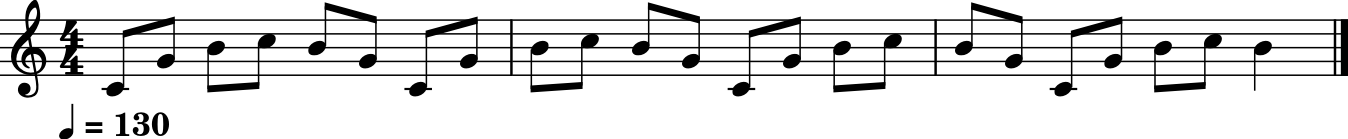

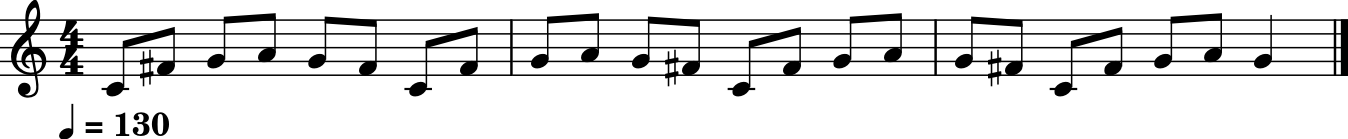

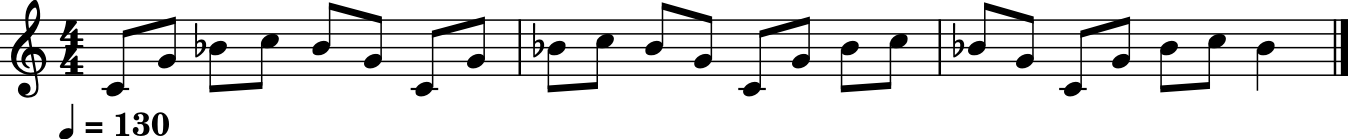

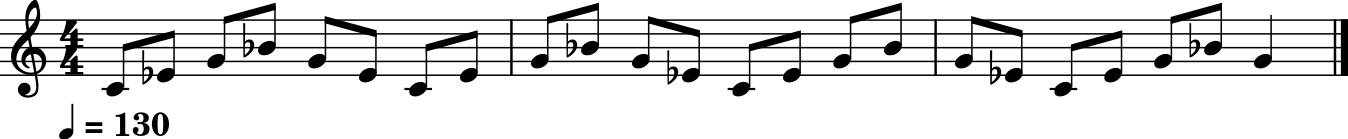

In [139]:
# This is a sample arpeggio over the C major seven chord
arpMajSev = converter.parse('midi/ARP_00_CMaj7.mid')[0]
arpMajSev.insert(0, instrument.Piano())
arpMajSev.show()
# This is an arpeggio over the C major lydian (suspended) chord
# (i.e. instead of playing a sus4, we raise the 4th tone by a half tone,
# so it is playing over C lydian). Also note the sixth (A).
arpLydSus = converter.parse('midi/ARP_01_CLydSus.mid')[0]
arpLydSus.insert(0, instrument.Piano())
arpLydSus.show()
# Arpeggio over the C7 chord
arpDomSev = converter.parse('midi/ARP_02_C7.mid')[0]
arpDomSev.insert(0, instrument.Piano())
arpDomSev.show()
# Arpeggio over the Cmin7 chord
arpMinSev = converter.parse('midi/ARP_03_Cmin7.mid')[0]
arpMinSev.insert(0, instrument.Piano())
arpMinSev.show()

The palette of scales itself:

In [149]:
def create_palette():
    # By default, all scales are just modes with C as a tonic, but of course
    # it will be transposed, etc.; this is just to use "C" as a neutral element,
    # if notes were an algebra.
    
    ret = []
    # major/ionian
    cMaj = ['C', 'D', 'E', 'F', 'G', 'A', 'B']
    # lydian
    cLyd = ['C', 'D', 'E', 'F#', 'G', 'A', 'B']
    # minor/aeolian
    cMin = ['C', 'D', 'D#', 'F', 'G', 'G#', 'A#']
    # mixolydian
    cMyx = ['C', 'D', 'D#', 'F', 'G', 'A', 'A#']
    # add
    pitchC = pitch.Pitch('C')
    ret.append(Scale('major', pitchC, cMaj, arpMajSev))
    ret.append(Scale('lydian', pitchC, cLyd, arpLydSus))
    ret.append(Scale('myxlodian', pitchC, cMyx, arpDomSev))
    ret.append(Scale('minor', pitchC, cMin, arpMinSev))
    return ret

def random_scale_from_palette():
    return palette[random.randint(0, len(palette) - 1)]

palette = create_palette()
print(palette)

[C major, C lydian, C myxlodian, C minor]


## Creating the graph

In [118]:
# We will use networkx for the graphs and matplotlib for the visual representations
import networkx as nx
import matplotlib.pyplot as plt

In [25]:
def calculate_score(a, b):
    """
    Calculates the score between two scales. (See above for the description.)
    a: Scale
    b: Scale
    """
    notesA = a.notes
    notesB = b.notes
    return len(set(notesA) & set(notesB))

[C major]
[G lydian, C minor]
connecting C major to level 1
[G lydian, C minor]
[G minor, C myxlodian]
connecting G lydian to level 2
connecting C minor to level 2
[G minor, C myxlodian]
[D lydian, C myxlodian]
connecting G minor to level 3
connecting C myxlodian to level 3
[D lydian, C myxlodian]
[D minor, C myxlodian]
connecting D lydian to level 4
connecting C myxlodian to level 4


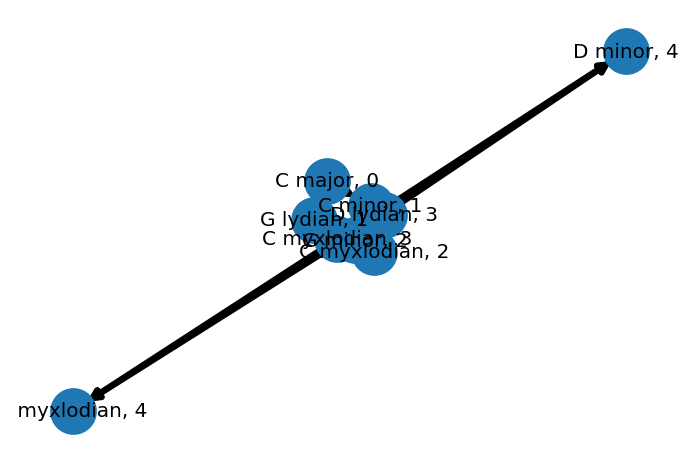

In [165]:
def node_name(scale, level):
    return str(scale) + ', ' + str(level)

def generate_structure_graph(tonic, levels, n):
    # generate the first node
    # I had never noticed that the upperbound was a possible result in Python :') (hence the - 1)
    first_scale = random_scale_from_palette().transposed(tonic)
    # create the graph
    graph = nx.DiGraph()
    # this will be reset at each iteration
    prev_level = [first_scale]
    for i in range(1, levels + 1):
        print(prev_level)
        current_level = []
        for j in range(0, n // 2):
            current_level.append(random_scale_from_palette().transposed(random_note()))
        for j in range(0, n // 2):
            current_level.append(random_scale_from_palette().transposed(tonic))
        print(current_level)
        for prev in prev_level:
            print(f"connecting {prev} to level {i}")
            for curr in current_level:
                graph.add_edge(node_name(prev, i - 1), node_name(curr, i), weight = calculate_score(prev, curr))
        prev_level = current_level
    
    # Display the graph
    pos = nx.spring_layout(graph)  # positions for all nodes

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=500)

    # edges
    nx.draw_networkx_edges(graph, pos, width=3, arrows=True)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=10, font_family="sans-serif")

    plt.axis("off")
    plt.show()
generate_structure_graph(pitch.Pitch('C'), 4, 2)